# Property Analysis for Rent Ready Home Purchase

This notebook analyzes property data to identify properties that fit defined criteria and ranks them based on desirability and seller likelihood.

## 1. Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os
import re


# Enable interactive plots
%matplotlib inline


# Set plotting style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 8]


# Set display options to see more columns
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)


# Print version info
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")
print(f"Seaborn version: {sns.__version__}")

Pandas version: 2.2.2
NumPy version: 1.26.4
Matplotlib version: 3.9.2
Seaborn version: 0.13.2


## 2. Load The Data

Load the property data, with an option to test on a small subset first.

In [2]:
def load_data(file_path):
    """
    Load and clean property data from CSV file.
    
    Args:
        file_path (str): Path to the CSV file
        
    Returns:
        pandas.DataFrame: Cleaned property data
    """
    print(f"Loading data from {file_path}...")
    
    # Use dtype parameter to specify data types upfront for more efficient loading
    # Also use low_memory=False to avoid mixed type inference warnings
    dtypes = {
        'SiteZIP': str,
        'LandUseDsc': str
    }
    
    properties = pd.read_csv(file_path, dtype=dtypes, low_memory=False)
    print(f"Original data shape: {properties.shape}")
    
    # Convert date columns - with a specific format for efficiency
    if 'DocRcrdgDt_County' in properties.columns:
        properties['DocRcrdgDt_County'] = pd.to_datetime(
            properties['DocRcrdgDt_County'], errors='coerce', format='%Y-%m-%d'
        )
    
    # Use vectorized operations instead of astype+str+replace chain
    currency_columns = [
        'MktTtlVal', 'SaleAmt_County', 'TaxTtl1', 'TaxTtl2', 'TaxTtl3'
    ]
    for col in currency_columns:
        if col in properties.columns:
            # This is more efficient than the chain of operations
            properties[col] = pd.to_numeric(
                properties[col].astype(str).str.replace(r'[\$,]', '', regex=True),
                errors='coerce'
            )
    
    # Handle other numeric columns in a batch when possible
    other_numeric_columns = [
        'BsmtFinSqFt', 'BsmtUnFinSqFt', 'BathHalfCt', 'Bath3QtrCt',
        'BathFullCt', 'BathTtlCt', 'BedCt', 'BldgSqFt', 'LotSqFt',
        'YrBlt', 'StoriesCt', 'Acres'
    ]
    
    # Check which columns exist first
    existing_num_cols = [col for col in other_numeric_columns if col in properties.columns]
    if existing_num_cols:
        properties[existing_num_cols] = properties[existing_num_cols].apply(
            pd.to_numeric, errors='coerce'
        )
    
    # Use boolean conversion directly where possible
    boolean_columns = [
        'OwnerOccupiedInd', 'BareLandInd', 'InvestmentProp', 
        'BankOwnedInd', 'OwnerCorporateInd'
    ]
    for col in boolean_columns:
        if col in properties.columns:
            properties[col] = properties[col].map({
                'TRUE': True, 'FALSE': False, True: True, False: False
            })
    
    print(f"Cleaned data shape: {properties.shape}")
    print(f"Sample market values: {properties['MktTtlVal'].dropna().head().tolist()}")
    
    return properties

### 3. Data Loading Function

Define a function to load and clean the property data CSV.

In [3]:
# Set path to your data file
file_path = "../data/Category_1.csv"

# Load and clean data
properties = load_data(file_path)

Loading data from ../data/Category_1.csv...
Original data shape: (1067, 147)
Cleaned data shape: (1067, 147)
Sample market values: [1159000.0, 972000.0, 737000.0, 721000.0, 565000.0]


## 4. Examine the Data

Let's examine the data to understand what we're working with.

In [4]:
# Display a few sample rows
properties.head()

,ParcelId,OwnerNmFirstBoth,OwnerNmLast,SiteAddr,SiteCity,SiteState,SiteZIP,SiteZipFull,SiteZIPPlus4,SiteCarrierCd,OwnerAddr,OwnerCityNm,OwnerZIP,OwnerState,OwnerCntryNm,OwnerZipFull,OwnerZIPPlus4,Acres,AssdImprVal,AssdLandVal,AssdTtlVal,AssmtYr,AssrMapLnk,BareLandInd,BsmtFinSqFt,...,TaxTtl3,TaxYr1,TaxYr2,TaxYr3,TaxAcctNum,TaxPyrAddr,TaxPyrCntryNm,TaxPyrNmFirst,TaxPyrNmLast,TaxPyrNm,TaxPyrState,TaxPyrZIP,Twn,TRS,UnfinTtlSqFt,SiteUnit,ViewDsc,WtrSrc,WtrfntNm,WtrfntFt,WtrshdCd,WtrshdDsc,YrBlt,ZoneCd,ZoneDsc
0,34001188,Peter & Catherine,Jensen,4435 SW Rose St,Seattle,WA,98136,98136-2247,2247.0,C047,4435 SW Rose St,Seattle,98136,WA,NaN,98136-2247,2247.0,0.1435,"$385,000.00","$166,000.00","$551,000.00",2025,/FileService/FlatFile/WA/King/0034001188/1,False,150,...,1696.56,2025,2024,2023,3400118802,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24N,24N03E35,910,NaN,NaN,PUBLIC,NaN,0,1711001902,Lunds Gulch-Frontal Puget Sound,1981,Seattle-NR3,Residential Neighborhood 3
1,34001766,Barbara,Cane,8218 Northrop Pl SW,Seattle,WA,98136,98136-2244,2244.0,C047,8218 Northrop Pl SW,Seattle,98136,WA,NaN,98136-2244,2244.0,0.1446,"$129,000.00","$105,900.00","$234,900.00",2025,/FileService/FlatFile/WA/King/0034001766/1,False,640,...,8636.88,2025,2024,2023,3400176602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24N,24N03E35,650,NaN,Puget Sound,PUBLIC,NaN,0,1711001902,Lunds Gulch-Frontal Puget Sound,1977,Seattle-NR3,Residential Neighborhood 3
2,37000235,Ryan & Rose,Behbahani,9827 35th Ave SW,Seattle,WA,98126,98126-4005,4005.0,C071,9827 35th Av SW,Seattle,98126,WA,NaN,98126-4005,4005.0,0.1343,"$375,000.00","$362,000.00","$737,000.00",2025,/FileService/FlatFile/WA/King/0037000235/1,False,0,...,6331.10,2025,2024,2023,3700023504,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23N,23N03E02,1270,NaN,NaN,PUBLIC,NaN,0,1711001902,Lunds Gulch-Frontal Puget Sound,1945,Seattle-NR3,Residential Neighborhood 3
3,37000345,Jake & Karlee,Charlton,3551 SW 99th St,Seattle,WA,98126,98126-4023,4023.0,C071,3551 SW 99th St,Seattle,98126,WA,NaN,98126-4023,4023.0,0.1221,"$339,000.00","$382,000.00","$721,000.00",2025,/FileService/FlatFile/WA/King/0037000345/1,False,1110,...,6704.57,2025,2024,2023,3700034501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23N,23N03E02,0,NaN,NaN,PUBLIC,NaN,0,1711001902,Lunds Gulch-Frontal Puget Sound,1921,Seattle-NR3,Residential Neighborhood 3
4,56000015,Erik,Nyberg,3036 59th Ave SW,Seattle,WA,98116,98116-2820,2820.0,C004,3036 59th SW,Seattle,98116,WA,NaN,98116-2820,2820.0,0.1790,"$1,000.00","$564,000.00","$565,000.00",2025,/FileService/FlatFile/WA/King/0056000015/1,False,300,...,5285.87,2025,2024,2023,5600001506,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24N,24N03E10,1580,NaN,NaN,PUBLIC,NaN,0,1711001902,Lunds Gulch-Frontal Puget Sound,1951,Seattle-LR1,Lowrise 1 Multi-Family


In [5]:
# Check data types and missing values
properties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067 entries, 0 to 1066
Columns: 147 entries, ParcelId to ZoneDsc
dtypes: bool(6), datetime64[ns](1), float64(29), int64(47), object(64)
memory usage: 1.2+ MB


In [6]:
# Look at statistics for numeric columns
properties.describe()

,ParcelId,SiteZIPPlus4,OwnerZIP,OwnerCntryNm,OwnerZIPPlus4,Acres,AssmtYr,BsmtFinSqFt,BsmtUnFinSqFt,BathHalfCt,Bath3QtrCt,BathFullCt,BathTtlCt,BedCt,BldgCt,BldgSqFt,CensBlock,CensTract,ComTtlSqFt,ComUseDsc,CompletePct,CondoLevel,CondoNm,CondoUnitCt,ConstTypeDsc,...,DocRcrdgDt_County,SaleAmt_County,SchDistCd,Sec,StoriesCt,TCA,TaxTtl1,TaxTtl2,TaxTtl3,TaxYr1,TaxYr2,TaxYr3,TaxAcctNum,TaxPyrAddr,TaxPyrCntryNm,TaxPyrNmFirst,TaxPyrNmLast,TaxPyrNm,TaxPyrState,TaxPyrZIP,UnfinTtlSqFt,SiteUnit,WtrfntFt,WtrshdCd,YrBlt
count,1.067000e+03,1065.000000,1067.000000,0.0,1058.000000,1067.000000,1067.0,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.0,0.0,1067.0,0.0,0.0,1067.0,0.0,...,0,1.067000e+03,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.0,1067.0,1067.0,1.067000e+03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1067.000000,0.0,1067.000000,1.067000e+03,1067.000000
mean,4.882906e+09,2318.136150,98112.773196,NaN,2314.488658,0.146638,2025.0,653.058107,330.136832,0.305530,0.422680,1.935333,2.405108,3.677601,1.003749,2233.375820,2200.589503,11354.995314,0.0,NaN,0.0,NaN,NaN,0.0,NaN,...,NaT,3.755091e+05,10.372071,25.898782,1.197751,100.028116,6885.381556,6338.977338,6045.412277,2025.0,2024.0,2023.0,4.882906e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,330.136832,NaN,0.044986,1.711002e+09,1964.825679
min,3.400119e+07,1004.000000,98016.000000,NaN,1004.000000,0.031400,2025.0,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,3.000000,1.000000,1600.000000,1000.000000,9600.000000,0.0,NaN,0.0,NaN,NaN,0.0,NaN,...,NaT,0.000000e+00,1.000000,1.000000,1.000000,10.000000,418.230000,415.840000,388.320000,2025.0,2024.0,2023.0,3.400119e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,1.711001e+09,1900.000000
25%,3.278614e+09,1635.000000,98106.000000,NaN,1633.000000,0.114700,2025.0,480.000000,0.000000,0.000000,0.000000,2.000000,2.000000,3.000000,1.000000,1950.000000,1014.500000,10702.000000,0.0,NaN,0.0,NaN,NaN,0.0,NaN,...,NaT,1.632500e+05,1.000000,24.000000,1.000000,10.000000,6889.505000,6255.880000,5942.435000,2025.0,2024.0,2023.0,3.278614e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,1.711001e+09,1941.000000
50%,3.438503e+09,2110.000000,98106.000000,NaN,2110.000000,0.134300,2025.0,700.000000,310.000000,0.000000,0.000000,2.000000,2.250000,4.000000,1.000000,2210.000000,2007.000000,10800.000000,0.0,NaN,0.0,NaN,NaN,0.0,NaN,...,NaT,3.350000e+05,1.000000,25.000000,1.000000,10.000000,7403.080000,6699.450000,6359.980000,2025.0,2024.0,2023.0,3.438503e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,310.000000,NaN,0.000000,1.711002e+09,1970.000000
75%,7.899800e+09,2901.000000,98126.000000,NaN,2900.750000,0.174700,2025.0,880.000000,510.000000,1.000000,1.000000,2.000000,2.750000,4.000000,1.000000,2440.000000,3007.000000,11401.000000,0.0,NaN,0.0,NaN,NaN,0.0,NaN,...,NaT,6.120000e+05,1.000000,31.000000,1.500000,10.000000,7771.720000,7082.460000,6721.850000,2025.0,2024.0,2023.0,7.899800e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,510.000000,NaN,0.000000,1.711002e+09,1991.000000
max,9.842300e+09,5113.000000,98146.000000,NaN,5113.000000,0.693100,2025.0,1720.000000,1690.000000,2.000000,2.000000,5.000000,5.000000,7.000000,2.000000,4110.000000,5015.000000,26600.000000,0.0,NaN,0.0,NaN,NaN,0.0,NaN,...,NaT,1.265100e+06,401.000000,36.000000,3.000000,3850.000000,9877.770000,15541.880000,16285.130000,2025.0,2024.0,2023.0,9.842300e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1690.000000,NaN,48.000000,1.711002e+09,2020.000000
std,2.586925e+09,860.133813,11.386898,NaN,856.910546,0.063459,0.0,340.403467,300.105985,0.496136,0.629461,0.603724,0.413713,0.745905,0.061141,396.204801,1047.117751,2551.422626,0.0,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,2.705269e+05,60.534512,7.814396,0.362753,581.122885,1740.728505,1517.739765,1404.857665,0.0,0.0,0.0,2.586925e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,300.105985,NaN,1.469464,2.621226e+02,30.336722


In [7]:
# Check which ZIP codes are present
if 'SiteZIP' in properties.columns:
    print("ZIP code counts:")
    print(properties['SiteZIP'].value_counts())

ZIP code counts:
SiteZIP
98106    722
98126    211
98136     80
98116     54
Name: count, dtype: int64


In [8]:
# Check distribution of property types
if 'LandUseDsc' in properties.columns:
    print("Land use types:")
    print(properties['LandUseDsc'].value_counts().head(10))

Land use types:
LandUseDsc
Single Family(Res Use/Zone)    1048
Duplex                           19
Name: count, dtype: int64


## 5. Filter Functions

Define functions to filter properties based on our criteria.

In [9]:
def filter_category1(properties):
    """
    Apply Category 1 (Rent-Ready Properties) filters
    """
    print("Filtering for Category 1 (Rent-Ready Properties) with criteria:")
    print("  - At least 2 bathrooms")
    print("  - At least 3 bedrooms")
    print("  - In ZIP codes: 98106, 98116, 98126, 98136")
    print("  - Market value <= $850,000")
    print("  - Property type: Single Family or Duplex")

    # Normalize key fields
    if 'SiteZIP' in properties.columns:
        properties['SiteZIP'] = properties['SiteZIP'].astype(str).str.strip()
    
    if 'LandUseDsc' in properties.columns:
        properties['LandUseDsc'] = properties['LandUseDsc'].astype(str).str.strip()

    category1_filter = (
        (properties['BathTtlCt'] >= 2) &
        (properties['BedCt'] >= 3) &
        (properties['SiteZIP'].isin(['98106', '98116', '98126', '98136'])) &
        (properties['MktTtlVal'] <= 850000) &
        (
            properties['LandUseDsc'].str.contains('Single Family', case=False, na=False) |
            properties['LandUseDsc'].str.contains('Duplex', case=False, na=False)
        )
    )

    cat1_properties = properties[category1_filter].copy()

    print(f"Found {len(cat1_properties)} properties matching Category 1 criteria out of {len(properties)} total properties")
    
    if len(cat1_properties) > 0:
        print("\nBreakdown by ZIP code:")
        print(cat1_properties['SiteZIP'].value_counts())

    return cat1_properties

def calculate_zip_averages(properties):
    """
    Calculate average values by ZIP code
    
    Args:
        properties (pandas.DataFrame): Property data
        
    Returns:
        pandas.DataFrame: Average values by ZIP code
    """
    zip_averages = properties.groupby('SiteZIP')['MktTtlVal'].mean().reset_index()
    zip_averages.rename(columns={'MktTtlVal': 'ZipAvgValue'}, inplace=True)
    
    print("ZIP code average values:")
    print(zip_averages)
    
    return zip_averages

## 6. Apply Filters

Let's apply the filters and see what properties match our criteria.

In [10]:
# Apply Category 1 filters
cat1_properties = filter_category1(properties)


# Display the first few properties that match
if len(cat1_properties) > 0:
    # Select a subset of columns to display
    display_columns = [
        'SiteAddr', 'SiteCity', 'SiteZIP', 'BathTtlCt', 'BedCt',
        'BldgSqFt', 'LotSqFt', 'YrBlt', 'MktTtlVal', 'LandUseDsc'
    ]
    
    # Make sure all requested columns exist
    display_columns = [col for col in display_columns if col in cat1_properties.columns]
    
    print("\nSample of matching Category 1 properties:")
    display(cat1_properties[display_columns].head())
else:
    print("\nNo properties match Category 1 criteria.")


# Calculate neighborhood averages
if len(cat1_properties) > 0:
    zip_averages = calculate_zip_averages(cat1_properties)
    
    # Merge with the properties dataframe
    cat1_properties = cat1_properties.merge(zip_averages, on='SiteZIP', how='left')

Filtering for Category 1 (Rent-Ready Properties) with criteria:
  - At least 2 bathrooms
  - At least 3 bedrooms
  - In ZIP codes: 98106, 98116, 98126, 98136
  - Market value <= $850,000
  - Property type: Single Family or Duplex
Found 1030 properties matching Category 1 criteria out of 1067 total properties

Breakdown by ZIP code:
SiteZIP
98106    717
98126    204
98136     72
98116     37
Name: count, dtype: int64

Sample of matching Category 1 properties:


,SiteAddr,SiteCity,SiteZIP,BathTtlCt,BedCt,BldgSqFt,LotSqFt,YrBlt,MktTtlVal,LandUseDsc
2,9827 35th Ave SW,Seattle,98126,2.00,3,3130,5850,1945,737000.0,Single Family(Res Use/Zone)
3,3551 SW 99th St,Seattle,98126,2.00,4,2680,5320,1921,721000.0,Single Family(Res Use/Zone)
4,3036 59th Ave SW,Seattle,98116,2.00,4,3760,7798,1951,565000.0,Duplex
5,6511 36th Ave SW,Seattle,98126,2.25,4,2230,6420,1926,761000.0,Single Family(Res Use/Zone)
6,3711 SW Morgan St,Seattle,98126,2.00,3,2030,2328,1916,693000.0,Single Family(Res Use/Zone)


ZIP code average values:
  SiteZIP    ZipAvgValue
0   98106  706964.087866
1   98116  733864.864865
2   98126  735256.750000
3   98136  748138.888889


## 7. Exploratory Data Analysis

Let's visualize some aspects of the filtered properties to better understand them.

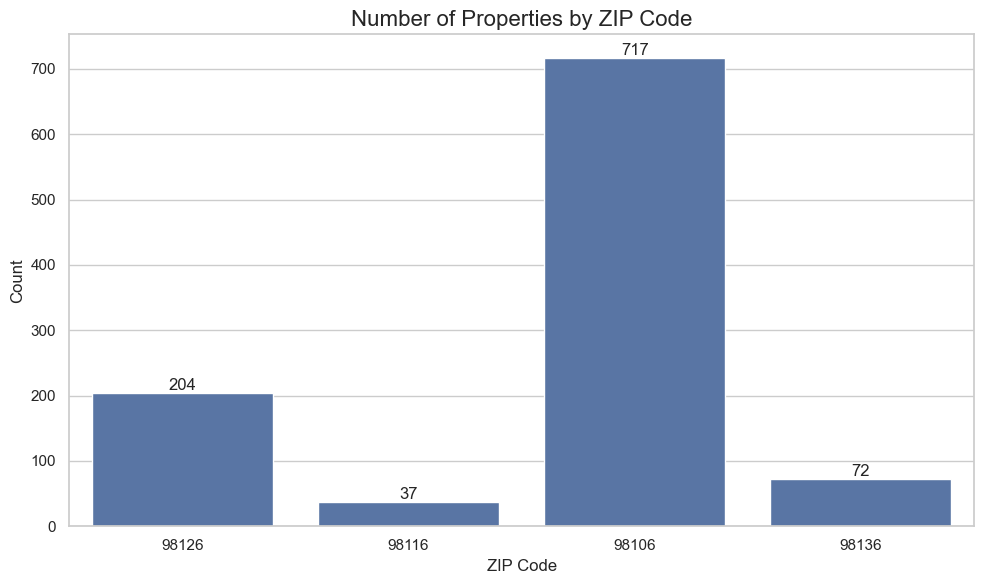

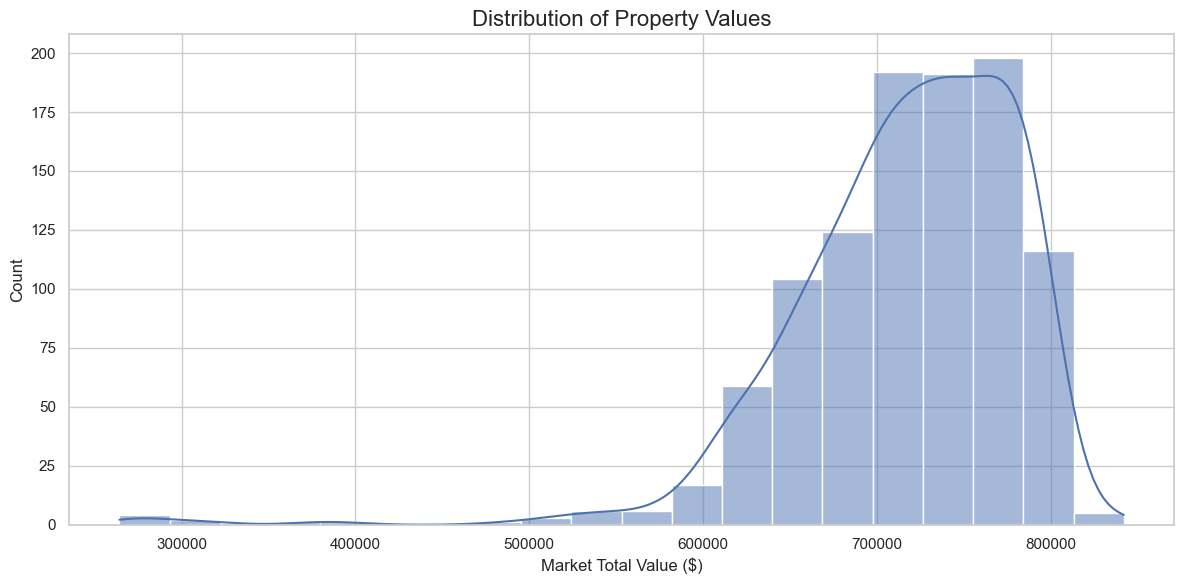

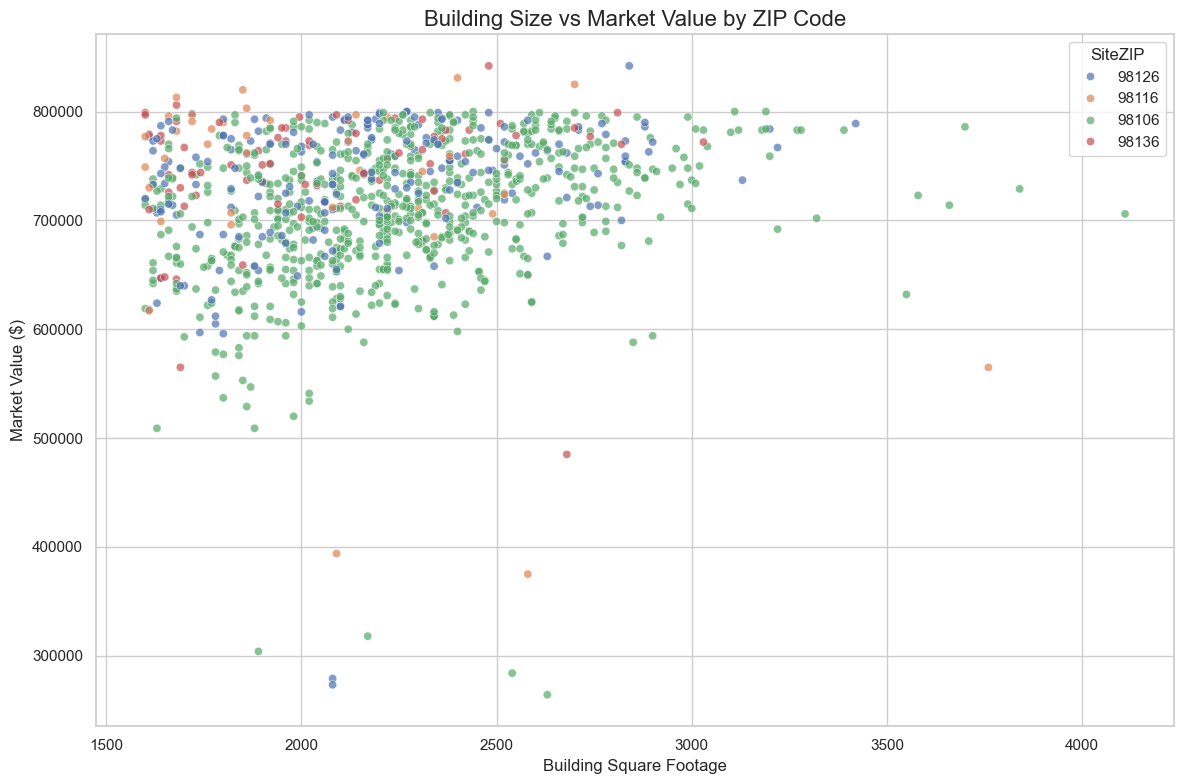

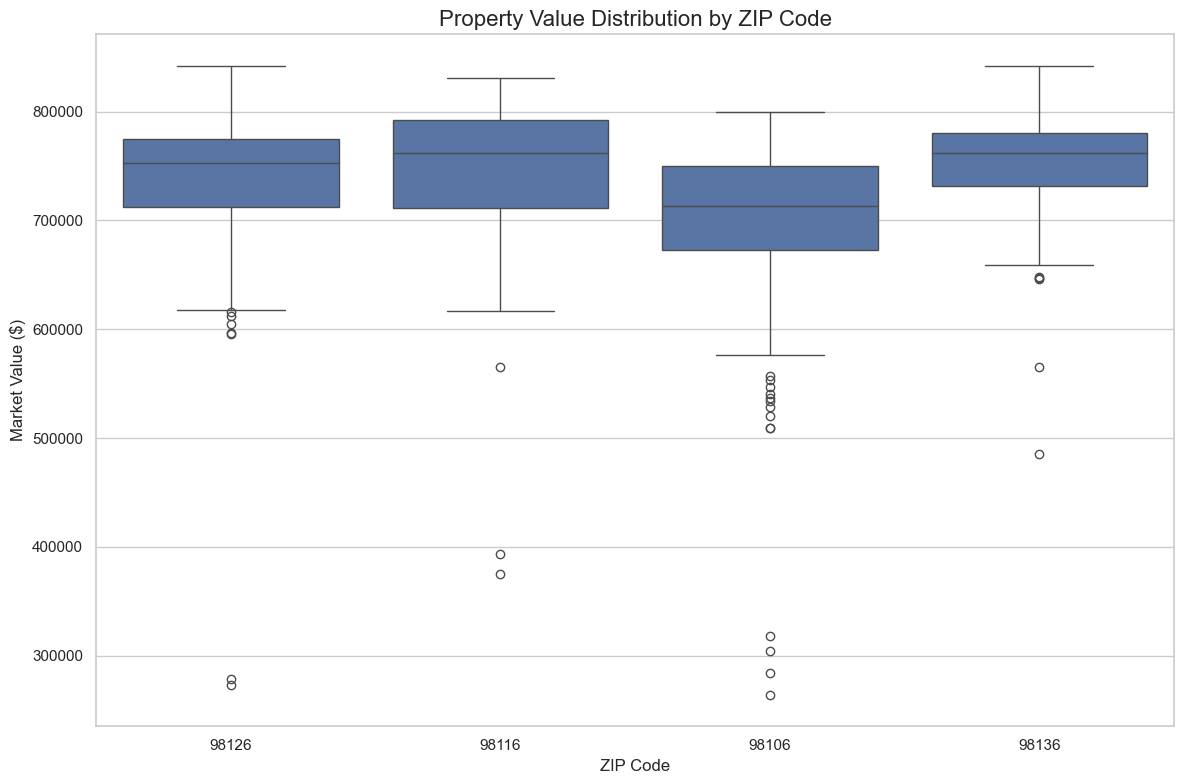

In [11]:
# Only run if we have matching properties
if len(cat1_properties) > 0:
    # Distribution of properties by ZIP code
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(data=cat1_properties, x='SiteZIP')
    plt.title('Number of Properties by ZIP Code', fontsize=16)
    plt.xlabel('ZIP Code', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    
    # Add counts on top of bars
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='bottom', fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    # Distribution of property values
    plt.figure(figsize=(12, 6))
    sns.histplot(cat1_properties['MktTtlVal'], bins=20, kde=True)
    plt.title('Distribution of Property Values', fontsize=16)
    plt.xlabel('Market Total Value ($)', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # Building Size vs Market Value
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=cat1_properties, x='BldgSqFt', y='MktTtlVal', hue='SiteZIP', alpha=0.7)
    plt.title('Building Size vs Market Value by ZIP Code', fontsize=16)
    plt.xlabel('Building Square Footage', fontsize=12)
    plt.ylabel('Market Value ($)', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # Boxplot of property values by ZIP code
    plt.figure(figsize=(12, 8))
    sns.boxplot(data=cat1_properties, x='SiteZIP', y='MktTtlVal')
    plt.title('Property Value Distribution by ZIP Code', fontsize=16)
    plt.xlabel('ZIP Code', fontsize=12)
    plt.ylabel('Market Value ($)', fontsize=12)
    plt.tight_layout()
    plt.show()

## 8. Scoring Functions - Desirability - Category 1

Now let's define functions to scorecat1 each property on desirability factors.

In [33]:
#========== DESIRABILITY SCORE FUNCTIONS - CATEGORY 1==========


def calculate_property_type_scorecat1(row):
    """
    Calculate property type scorecat1 (15 points max)
    
    Args:
        row (pandas.Series): Row of property data
        
    Returns:
        int: ScoreCat1 between 0-15
    """
    if pd.notna(row['LandUseDsc']) and "Duplex" in str(row['LandUseDsc']):
        return 15
    elif (pd.notna(row['LandUseDsc']) and "Single Family" in str(row['LandUseDsc']) and 
          ((pd.notna(row['BsmtFinSqFt']) and row['BsmtFinSqFt'] > 500) or 
           (pd.notna(row['BathFullCt']) and row['BathFullCt'] >= 2))):
        return 10
    elif pd.notna(row['LandUseDsc']) and "Single Family" in str(row['LandUseDsc']):
        return 5
    else:
        return 0




def calculate_bathroom_distribution_scorecat1(row):
    """
    Calculate bathroom distribution scorecat1 (15 points max)
    
    Args:
        row (pandas.Series): Row of property data
        
    Returns:
        int: ScoreCat1 between 0-15
    """
    bath_full = row['BathFullCt'] if pd.notna(row['BathFullCt']) else 0
    bath_3qtr = row['Bath3QtrCt'] if pd.notna(row['Bath3QtrCt']) else 0
    bath_half = row['BathHalfCt'] if pd.notna(row['BathHalfCt']) else 0
    
    if bath_full >= 2 and bath_3qtr >= 1:
        return 15
    elif bath_full == 2 and bath_half >= 1:
        return 12
    elif bath_full == 1 and bath_3qtr >= 1:
        return 10
    else:
        return 5




def calculate_building_size_scorecat1(row):
    """
    Calculate building size scorecat (10 points max)
    
    Args:
        row (pandas.Series): Row of property data
        
    Returns:
        int: ScoreCat1 between 0-10
    """
    if pd.notna(row['BldgSqFt']):
        if row['BldgSqFt'] > 2500:
            return 10
        elif row['BldgSqFt'] >= 2000:
            return 8
        elif row['BldgSqFt'] >= 1800:
            return 6
        elif row['BldgSqFt'] >= 1600:
            return 4
        else:
            return 2
    return 0


def calculate_basement_space_scorecat1(row):
    """
    Calculate basement space score for Category 1 (10 points max)
    For conversion-ready properties, unfinished basement space is preferred
    
    Args:
        row (pandas.Series): Row of property data
        
    Returns:
        int: Score between 0-10
    """
    bsmt_fin = row['BsmtFinSqFt'] if pd.notna(row['BsmtFinSqFt']) else 0
    bsmt_unfin = row['BsmtUnFinSqFt'] if pd.notna(row['BsmtUnFinSqFt']) else 0
    
    # For conversion-ready properties, unfinished space is preferred
    if bsmt_fin > 800:
        return 10  # Large unfinished basement (ideal for conversion)
    elif bsmt_fin >= 500:
        return 8   # Good unfinished space for conversion
    elif bsmt_fin >= 300:
        return 6   # Mix of finished/unfinished space
    elif bsmt_fin > 200:
        return 4   # Already finished (less flexible for conversion)
    elif (bsmt_fin + bsmt_unfin) > 0:
        return 2   # Some basement is better than none
    else:
        return 0   # No basement


def calculate_stories_count_scorecat1(row):
    """
    Calculate stories count scorecat1 (5 points max)
    
    Args:
        row (pandas.Series): Row of property data
        
    Returns:
        int: ScoreCat1 between 0-5
    """
    bsmt_fin = row['BsmtFinSqFt'] if pd.notna(row['BsmtFinSqFt']) else 0
    bsmt_unfin = row['BsmtUnFinSqFt'] if pd.notna(row['BsmtUnFinSqFt']) else 0
    
    if pd.notna(row['StoriesCt']) and row['StoriesCt'] >= 2:
        return 5
    elif pd.notna(row['StoriesCt']) and row['StoriesCt'] == 1 and (bsmt_fin > 0 or bsmt_unfin > 0):
        return 3
    else:
        return 1




def calculate_zip_code_value_scorecat1(row):
    """
    Calculate ZIP code value scorecat1 (15 points max)
    
    Args:
        row (pandas.Series): Row of property data
        
    Returns:
        int: ScoreCat1 between 0-15
    """
    if pd.notna(row['SiteZIP']):
        if row['SiteZIP'] == '98116':
            return 15
        elif row['SiteZIP'] == '98136':
            return 12
        elif row['SiteZIP'] == '98126':
            return 10
        elif row['SiteZIP'] == '98106':
            return 8
        else:
            return 5
    return 5




def calculate_lot_size_scorecat1(row):
    """
    Calculate lot size scorecat1 (10 points max)
    
    Args:
        row (pandas.Series): Row of property data
        
    Returns:
        int: ScoreCat1 between 0-10
    """
    if pd.notna(row['LotSqFt']):
        if row['LotSqFt'] > 8000:
            return 10
        elif row['LotSqFt'] >= 6000:
            return 8
        elif row['LotSqFt'] >= 5000:
            return 6
        else:
            return 4
    return 0




def calculate_condition_scorecat1(row):
    """
    Calculate condition scorecat1 (10 points max)
    
    Args:
        row (pandas.Series): Row of property data
        
    Returns:
        int: ScoreCat1 between 0-10
    """
    if pd.notna(row['Condition']):
        condition = str(row['Condition']).strip().lower()
        if condition == 'excellent':
            return 10
        elif condition == 'good':
            return 8
        elif condition == 'average':
            return 6
        elif condition == 'fair':
            return 4
        else:
            return 2
    return 0




def calculate_year_built_scorecat1(row):
    """
    Calculate year built scorecat1 (10 points max)
    
    Args:
        row (pandas.Series): Row of property data
        
    Returns:
        int: ScoreCat1 between 0-10
    """
    if pd.notna(row['YrBlt']):
        if row['YrBlt'] >= 2000:
            return 10
        elif row['YrBlt'] >= 1980:
            return 8
        elif row['YrBlt'] >= 1960:
            return 6
        elif row['YrBlt'] >= 1940:
            return 4
        else:
            return 2
    return 0

def calculate_zoning_scorecat1(row):
    """
    Calculate zoning score for Category 1 (Rent-Ready Properties) (10 points max)
    Evaluates zoning compatibility with existing or potential rental units
    
    Args:
        row (pandas.Series): Row of property data
        
    Returns:
        int: Score between 0-10
    """
    if pd.notna(row['ZoneCd']):
        zone_code = str(row['ZoneCd']).strip()
        
        # Duplex/multi-family zones score highest
        if any(code in zone_code for code in ['LR2', 'LR3', 'RD', 'MDR']):
            return 10  # Lowrise multi-family or residential duplex zones - ideal for rentals
        
        # Zones that explicitly allow ADUs or additional units
        elif 'RSL' in zone_code or 'DADU' in zone_code:
            return 9  # Residential Small Lot or Detached Accessory Dwelling Unit zones
            
        # Higher density residential zones
        elif any(code in zone_code for code in ['R-18', 'R-24', 'NR3']):
            return 8  # Higher density residential zones with rental potential
            
        # Medium density residential
        elif any(code in zone_code for code in ['NR2', 'R-12']):
            return 6  # Medium density residential
            
        # Lower density residential with potential for conversion
        elif any(code in zone_code for code in ['R-6', 'R-8']):
            return 4  # Lower density residential, but still with some potential
            
        # Other residential zones not clearly categorized
        elif 'R-' in zone_code:
            return 3  # Other residential zones with limited rental potential
            
        # Non-residential or industrial zones
        elif 'UI' in zone_code or 'IC' in zone_code:
            return 0  # Urban Industrial or Industrial Commercial - not suitable for residential
            
        else:
            return 2  # Unknown zoning
    
    return 0  # No zoning information available

In [34]:
# Test these functions on a sample property to see if they work as expected
def test_desirability_scoring_functions():
    # Create a sample property for testing
    sample_property = pd.Series({
        'LandUseDsc': 'Single Family(Res Use/Zone)',
        'BsmtFinSqFt': 700,
        'BsmtUnFinSqFt': 500,
        'BathFullCt': 2,
        'Bath3QtrCt': 1,
        'BathHalfCt': 0,
        'BldgSqFt': 2200,
        'StoriesCt': 1,
        'SiteZIP': '98126',
        'LotSqFt': 7000,
        'Condition': 'Good',
        'YrBlt': 1985 ,
        'ZoneCd' : 'Residential Small Lot'
    })
    
    # Test each scoring function
    print("Testing desirability scoring functions on sample property...")
    print(f"Property Type ScoreCat1: {calculate_property_type_scorecat1(sample_property)}")
    print(f"Bathroom Distribution ScoreCat1: {calculate_bathroom_distribution_scorecat1(sample_property)}")
    print(f"Building Size ScoreCat1: {calculate_building_size_scorecat1(sample_property)}")
    print(f"Basement Space ScoreCat1: {calculate_basement_space_scorecat1(sample_property)}")
    print(f"Stories Count ScoreCat1: {calculate_stories_count_scorecat1(sample_property)}")
    print(f"ZIP Code Value ScoreCat1: {calculate_zip_code_value_scorecat1(sample_property)}")
    print(f"Lot Size ScoreCat1: {calculate_lot_size_scorecat1(sample_property)}")
    print(f"Condition ScoreCat1: {calculate_condition_scorecat1(sample_property)}")
    print(f"Year Built ScoreCat1: {calculate_year_built_scorecat1(sample_property)}")
    
    # Calculate total desirability scorecat1
    total_scorecat1 = (
        calculate_property_type_scorecat1(sample_property) +
        calculate_bathroom_distribution_scorecat1(sample_property) +
        calculate_building_size_scorecat1(sample_property) +
        calculate_basement_space_scorecat1(sample_property) +
        calculate_stories_count_scorecat1(sample_property) +
        calculate_zip_code_value_scorecat1(sample_property) +
        calculate_lot_size_scorecat1(sample_property) +
        calculate_condition_scorecat1(sample_property) +
        calculate_year_built_scorecat1(sample_property) +
        calculate_zoning_scorecat1(sample_property)
    )
    
    print(f"Total Desirability ScoreCat1: {total_scorecat1}")




# Run the test to see if our scoring functions work correctly
test_desirability_scoring_functions()

Testing desirability scoring functions on sample property...
Property Type ScoreCat1: 10
Bathroom Distribution ScoreCat1: 15
Building Size ScoreCat1: 8
Basement Space ScoreCat1: 8
Stories Count ScoreCat1: 3
ZIP Code Value ScoreCat1: 10
Lot Size ScoreCat1: 8
Condition ScoreCat1: 8
Year Built ScoreCat1: 8
Total Desirability ScoreCat1: 80


## 9. Calculate Cat1 Seller Likelihood

Determine seller likelihood for all filtered properties.

In [35]:
def calculate_seller_likelihood_score(properties_df):
    """
    Calculate the likelihood of sellers being willing to sell their Rent-Ready properties.
    
    Parameters:
    -----------
    properties_df : pandas DataFrame
        DataFrame containing property information for Category 1 properties
    
    Returns:
    --------
    pandas DataFrame
        Original DataFrame with added seller likelihood score and factors
    """
    # Make a copy of the dataframe to avoid modifying the original
    df = properties_df.copy()
    
    # Initialize the seller likelihood score column
    df['SellerLikelihoodScore'] = 0
    df['SellerLikelihoodFactors'] = ''
    
    # Length of ownership - properties owned longer may be more likely to sell
    if 'DocRcrdgDt_County' in df.columns:
        df['OwnershipLength'] = pd.Timestamp.now().year - pd.to_datetime(df['DocRcrdgDt_County']).dt.year
        # Higher scores for longer ownership (with diminishing returns after 15 years)
        df.loc[df['OwnershipLength'] >= 15, 'SellerLikelihoodScore'] += 15
        df.loc[(df['OwnershipLength'] >= 7) & (df['OwnershipLength'] < 15), 'SellerLikelihoodScore'] += 10
        df.loc[(df['OwnershipLength'] >= 2) & (df['OwnershipLength'] < 7), 'SellerLikelihoodScore'] += 5
        
        # Add factor description for long ownership
        df.loc[df['OwnershipLength'] >= 7, 'SellerLikelihoodFactors'] += 'Long-term owner; '
    
    # Tax assessment increases - rapidly increasing property taxes may motivate selling
    if all(col in df.columns for col in ['TaxTtl1', 'TaxTtl2', 'TaxTtl3']):
        # Convert tax columns to numeric if they aren't already
        for col in ['TaxTtl1', 'TaxTtl2', 'TaxTtl3']:
            if df[col].dtype == 'object':
                df[col] = df[col].str.replace('$', '').str.replace(',', '').astype(float)
        
        # Calculate year-over-year tax increases
        df['TaxChange_Recent'] = ((df['TaxTtl1'] - df['TaxTtl2']) / df['TaxTtl2']) * 100
        df['TaxChange_Previous'] = ((df['TaxTtl2'] - df['TaxTtl3']) / df['TaxTtl3']) * 100
        
        # High recent tax increases - more impactful for Category 1 properties due to higher values
        df.loc[df['TaxChange_Recent'] >= 10, 'SellerLikelihoodScore'] += 12
        df.loc[(df['TaxChange_Recent'] >= 5) & (df['TaxChange_Recent'] < 10), 'SellerLikelihoodScore'] += 6
        
        # Consistent tax increases over multiple years
        df.loc[(df['TaxChange_Recent'] >= 5) & (df['TaxChange_Previous'] >= 5), 'SellerLikelihoodScore'] += 5
        
        # Add factor description for high tax increases
        df.loc[df['TaxChange_Recent'] >= 10, 'SellerLikelihoodFactors'] += 'High recent tax increase; '
        df.loc[(df['TaxChange_Recent'] >= 5) & (df['TaxChange_Previous'] >= 5), 'SellerLikelihoodFactors'] += 'Sustained tax increases; '
    
    # Non-owner occupied properties may be more likely to sell
    if 'OwnerOccupiedInd' in df.columns:
        # For Category 1, investment properties are particularly attractive
        df.loc[df['OwnerOccupiedInd'] == False, 'SellerLikelihoodScore'] += 18
        df.loc[df['OwnerOccupiedInd'] == False, 'SellerLikelihoodFactors'] += 'Investment property; '
    
    # Corporate ownership might indicate investment property
    if 'OwnerCorporateInd' in df.columns:
        df.loc[df['OwnerCorporateInd'] == True, 'SellerLikelihoodScore'] += 10
        df.loc[df['OwnerCorporateInd'] == True, 'SellerLikelihoodFactors'] += 'Corporate owner; '
    
    # Different tax mailing address may indicate non-local owner
    if all(col in df.columns for col in ['OwnerAddr', 'SiteAddr']):
        df['DifferentMailingAddr'] = df['OwnerAddr'] != df['SiteAddr']
        df.loc[df['DifferentMailingAddr'], 'SellerLikelihoodScore'] += 12
        df.loc[df['DifferentMailingAddr'], 'SellerLikelihoodFactors'] += 'Non-local owner; '
    
    # Older owners may be more likely to downsize (inferred from ownership length)
    if 'OwnershipLength' in df.columns:
        df.loc[df['OwnershipLength'] >= 25, 'SellerLikelihoodScore'] += 5
        df.loc[df['OwnershipLength'] >= 25, 'SellerLikelihoodFactors'] += 'Potential downsizing candidate; '
    
    # Rent-Ready specific factors
    
    # Property condition - For Category 1, condition matters differently
    if 'Condition' in df.columns:
        # Lower scores for excellent condition (owners may charge premium rents)
        df.loc[df['Condition'].str.lower() == 'excellent', 'SellerLikelihoodScore'] += 3
        # Moderate scores for average condition (balanced investment)
        df.loc[df['Condition'].str.lower() == 'average', 'SellerLikelihoodScore'] += 8
        # Higher scores for fair/poor condition (may be challenging to maintain as rentals)
        df.loc[df['Condition'].str.lower().isin(['fair', 'poor']), 'SellerLikelihoodScore'] += 12
        
        df.loc[df['Condition'].str.lower().isin(['fair', 'poor']), 'SellerLikelihoodFactors'] += 'Property may need work (rental upkeep challenges); '
        df.loc[df['Condition'].str.lower() == 'average', 'SellerLikelihoodFactors'] += 'Balanced condition for rental; '
    
    # Check for duplex properties - these are already set up as rentals
    if 'LandUseDsc' in df.columns:
        # Higher scores for duplexes with non-owner occupation (investment properties)
        df.loc[(df['LandUseDsc'].str.lower().str.contains('duplex')) & 
               (df['OwnerOccupiedInd'] == False), 'SellerLikelihoodScore'] += 15
        df.loc[(df['LandUseDsc'].str.lower().str.contains('duplex')) & 
               (df['OwnerOccupiedInd'] == False), 'SellerLikelihoodFactors'] += 'Investment duplex; '
        
        # Lower scores for owner-occupied duplexes (house hacking situation)
        df.loc[(df['LandUseDsc'].str.lower().str.contains('duplex')) & 
               (df['OwnerOccupiedInd'] == True), 'SellerLikelihoodScore'] += 5
        df.loc[(df['LandUseDsc'].str.lower().str.contains('duplex')) & 
               (df['OwnerOccupiedInd'] == True), 'SellerLikelihoodFactors'] += 'Owner-occupied duplex; '
    
    # Property age considerations
    if 'YrBlt' in df.columns:
        # Older properties may have higher maintenance costs for landlords
        df.loc[df['YrBlt'] < 1960, 'SellerLikelihoodScore'] += 8
        df.loc[(df['YrBlt'] >= 1960) & (df['YrBlt'] < 1980), 'SellerLikelihoodScore'] += 5
        
        df.loc[df['YrBlt'] < 1960, 'SellerLikelihoodFactors'] += 'Older rental (potential maintenance issues); '
        df.loc[(df['YrBlt'] >= 1960) & (df['YrBlt'] < 1980), 'SellerLikelihoodFactors'] += 'Aging rental property; '
    
    # Finished basement likely indicates separate living space
    if 'BsmtFinSqFt' in df.columns:
        df.loc[df['BsmtFinSqFt'] > 800, 'SellerLikelihoodScore'] += 8
        df.loc[df['BsmtFinSqFt'] > 800, 'SellerLikelihoodFactors'] += 'Substantial finished basement (possible rental unit); '
    
    # Multiple bathrooms likely indicates separate living spaces
    if 'BathTtlCt' in df.columns:
        df.loc[df['BathTtlCt'] >= 3, 'SellerLikelihoodScore'] += 5
        df.loc[df['BathTtlCt'] >= 3, 'SellerLikelihoodFactors'] += 'Multiple bathrooms for separate units; '
    
    # Property value approaching price ceiling for profitable rentals
    if 'MktTtlVal' in df.columns:
        df.loc[df['MktTtlVal'] > 750000, 'SellerLikelihoodScore'] += 10
        df.loc[(df['MktTtlVal'] > 700000) & (df['MktTtlVal'] <= 750000), 'SellerLikelihoodScore'] += 5
        
        df.loc[df['MktTtlVal'] > 750000, 'SellerLikelihoodFactors'] += 'Value approaching rental profit threshold; '
        df.loc[(df['MktTtlVal'] > 700000) & (df['MktTtlVal'] <= 750000), 'SellerLikelihoodFactors'] += 'High value for rental property; '
    
    # Property size considerations for rental management
    if 'LotSqFt' in df.columns:
        # Very large lots can be maintenance-intensive for landlords
        df.loc[df['LotSqFt'] > 8000, 'SellerLikelihoodScore'] += 8
        df.loc[df['LotSqFt'] > 8000, 'SellerLikelihoodFactors'] += 'Large lot (high maintenance for rental); '
    
    # Normalize scores to a 0-100 scale
    max_possible_score = 90  # Based on the maximum score attainable from above factors
    df['SellerLikelihoodScore'] = (df['SellerLikelihoodScore'] / max_possible_score) * 100
    
    # Clamp scores to ensure they're between 0 and 100
    df['SellerLikelihoodScore'] = df['SellerLikelihoodScore'].clip(0, 100)
    
    # Create likelihood categories
    df['SellerLikelihoodCategory'] = pd.cut(
        df['SellerLikelihoodScore'], 
        bins=[0, 25, 50, 75, 100], 
        labels=['Low', 'Moderate', 'High', 'Very High']
    )
    
    # Clean up factors string (remove trailing semicolon and space)
    df['SellerLikelihoodFactors'] = df['SellerLikelihoodFactors'].str.rstrip('; ')
    
    return df

## 10. Calculate ScoreCat1s for All Properties

Apply the scoring functions to all filtered properties.

In [38]:
def calculate_all_scorecat1s(properties):
    """
    Calculate all individual scorecat1s for properties
    
    Args:
        properties (pandas.DataFrame): Property data
        
    Returns:
        pandas.DataFrame: Property data with scorecat1s
    """
    # Calculate desirability scorecat1s
    print("Calculating desirability scorecat1s...")
    properties['PropertyTypeScoreCat1'] = properties.apply(calculate_property_type_scorecat1, axis=1)
    properties['BathroomDistributionScoreCat1'] = properties.apply(calculate_bathroom_distribution_scorecat1, axis=1)
    properties['BuildingSizeScoreCat1'] = properties.apply(calculate_building_size_scorecat1, axis=1)
    properties['BasementSpaceScoreCat1'] = properties.apply(calculate_basement_space_scorecat1, axis=1)
    properties['StoriesCountScoreCat1'] = properties.apply(calculate_stories_count_scorecat1, axis=1)
    properties['ZipCodeValueScoreCat1'] = properties.apply(calculate_zip_code_value_scorecat1, axis=1)
    properties['LotSizeScoreCat1'] = properties.apply(calculate_lot_size_scorecat1, axis=1)
    properties['ConditionScoreCat1'] = properties.apply(calculate_condition_scorecat1, axis=1)
    properties['YearBuiltScoreCat1'] = properties.apply(calculate_year_built_scorecat1, axis=1)
    properties['ZoningScoreCat1'] = properties.apply(calculate_zoning_scorecat1, axis=1)
    
    return properties




def calculate_combined_scorecat1s(properties):
    """
    Calculate total and combined scorecat1s, and assign priority tiers
    
    Args:
        properties (pandas.DataFrame): Property data with individual scorecat1s
        
    Returns:
        pandas.DataFrame: Property data with total scorecat1s and priority tiers
    """
    # Calculate desirability scorecat1
    desirability_columns = [
        'PropertyTypeScoreCat1', 'BathroomDistributionScoreCat1', 'BuildingSizeScoreCat1',
        'BasementSpaceScoreCat1', 'StoriesCountScoreCat1', 'ZipCodeValueScoreCat1',
        'LotSizeScoreCat1', 'ConditionScoreCat1', 'YearBuiltScoreCat1', 'ZoningScoreCat1'
    ]
    
    properties['DesirabilityScoreCat1'] = properties[desirability_columns].sum(axis=1)
    
    # Calculate seller likelihood score
    properties = calculate_seller_likelihood_score(properties)
    
    # Calculate final combined score (weighted average)
    properties['FinalScoreCat1'] = (
        properties['DesirabilityScoreCat1'] * 0.7 + 
        properties['SellerLikelihoodScore'] * 0.3
    )
    
    # Assign priority tiers based on the combined final score
    def assign_tier(scorecat1):
        # Calculate max possible score
        max_desirability = 100  # 15+15+10+10+5+15+10+10+10+10 (includes zoning)
        max_seller = 110  # Total possible seller likelihood points
        max_combined = max_desirability * 0.7 + max_seller * 0.3
        
        if scorecat1 >= max_combined * 0.8:  # 80% or higher
            return "Tier 1"
        elif scorecat1 >= max_combined * 0.65:  # 65-80%
            return "Tier 2"
        elif scorecat1 >= max_combined * 0.5:  # 50-65%
            return "Tier 3"
        else:  # Below 50%
            return "Tier 4"
    
    properties['PriorityTier'] = properties['FinalScoreCat1'].apply(assign_tier)
    
    # Calculate max possible scores for reference
    max_desirability = 100
    max_seller = 110
    max_combined = max_desirability * 0.7 + max_seller * 0.3
    
    print("ScoreCat1 ranges for each tier:")
    print(f"  Tier 1: {max_combined * 0.8:.1f}-{max_combined:.1f}")
    print(f"  Tier 2: {max_combined * 0.65:.1f}-{max_combined * 0.8:.1f}")
    print(f"  Tier 3: {max_combined * 0.5:.1f}-{max_combined * 0.65:.1f}")
    print(f"  Tier 4: 0-{max_combined * 0.5:.1f}")
    
    return properties

In [39]:
# Apply scoring functions to Category 1 properties
if len(cat1_properties) > 0:
    # Calculate scorecat1s
    cat1_properties = calculate_all_scorecat1s(cat1_properties)
    cat1_properties = calculate_combined_scorecat1s(cat1_properties)
    
    # Display scorecat1 summary
    print("\nScoreCat1 summary statistics:")
    print(cat1_properties['DesirabilityScoreCat1'].describe())
    
    # Count properties by tier
    print("\nProperties by tier:")
    tier_counts = cat1_properties['PriorityTier'].value_counts().sort_index()
    print(tier_counts)
    
    # Display top 5 properties
    display_columns = [
        'SiteAddr', 'SiteCity', 'SiteZIP', 'BathTtlCt', 'BedCt',
        'BldgSqFt', 'YrBlt', 'MktTtlVal', 'DesirabilityScoreCat1', 'PriorityTier', 'ZoneCd'
    ]
    
    # Make sure all requested columns exist
    display_columns = [col for col in display_columns if col in cat1_properties.columns]
    
    print("\nTop 5 properties by final score:")
    top_properties = cat1_properties.sort_values('FinalScoreCat1', ascending=False)
    display(top_properties[display_columns].head())

Calculating desirability scorecat1s...
ScoreCat1 ranges for each tier:
  Tier 1: 82.4-103.0
  Tier 2: 67.0-82.4
  Tier 3: 51.5-67.0
  Tier 4: 0-51.5

ScoreCat1 summary statistics:
count    1030.000000
mean       71.269903
std         7.224228
min        48.000000
25%        66.000000
50%        71.500000
75%        77.000000
max        88.000000
Name: DesirabilityScoreCat1, dtype: float64

Properties by tier:
PriorityTier
Tier 2    185
Tier 3    770
Tier 4     75
Name: count, dtype: int64

Top 5 properties by final score:


,SiteAddr,SiteCity,SiteZIP,BathTtlCt,BedCt,BldgSqFt,YrBlt,MktTtlVal,DesirabilityScoreCat1,PriorityTier,ZoneCd
389,5935 21st Ave SW,Seattle,98106,2.25,5,2420,1977,773000.0,86,Tier 2,Seattle-NR3
445,6548 24th Ave SW,Seattle,98106,2.75,5,2860,1948,744000.0,84,Tier 2,Seattle-NR3
111,7743 20th Ave SW,Seattle,98106,2.50,6,3700,1967,786000.0,81,Tier 2,Seattle-NR3
456,1901 SW Holly St,Seattle,98106,2.50,3,2380,1968,761000.0,81,Tier 2,Seattle-NR3
327,5417 21st Ave SW,Seattle,98106,2.75,4,2100,1941,761000.0,82,Tier 2,Seattle-NR3


## 11.  Reorder Results

In [29]:
def reorder_columns(df, category):
    """
    Reorder columns based on the property category and recommended structure
    
    Parameters:
    df (DataFrame): The DataFrame containing property data and scores
    category (int): The category number (1, 2, or 3)
    
    Returns:
    DataFrame: A new DataFrame with reordered columns
    """
    # Define column groups
    scoring_cols = [
        'PriorityTier', 'DesirabilityScoreCat1', 'SellerLikelihoodScore', 'FinalScoreCat1'
    ]
    
    # Add factor score columns based on category
    if category == 1:  # Rent-Ready Properties
        factor_cols = [
            'PropertyTypeScoreCat1', 'BathroomDistributionScoreCat1', 'BuildingSizeScoreCat1',
            'BasementSpaceScoreCat1', 'StoriesCountScoreCat1', 'ZipCodeValueScoreCat1',
            'LotSizeScoreCat1', 'ConditionScoreCat1', 'YearBuiltScoreCat1', 'ZoningScoreCat1'
        ]
    
    # Basic property identification
    id_cols = [
        'SiteAddr', 'SiteCity', 'SiteState', 'SiteZIP', 'ParcelId', 'LandUseDsc'
    ]
    
    # Key property characteristics
    key_cols = [
        'MktTtlVal', 'BedCt', 'BathTtlCt', 'BldgSqFt', 'LotSqFt', 'Acres',
        'YrBlt', 'Condition'
    ]
    
    # Category-specific features
    if category == 1:  # Rent-Ready Properties
        category_cols = [
            'GarageDsc', 'BsmtFinSqFt', 'BsmtUnFinSqFt', 'StoriesCt', 'FireplaceCt'
        ]
    
    # Financial/tax information
    financial_cols = [
        'TaxTtl1', 'TaxYr1', 'AssdImprVal', 'AssdLandVal', 'AssdTtlVal'
    ]
    
    # Owner information
    owner_cols = [
        'OwnerNmFirstBoth', 'OwnerNmLast', 'OwnerOccupiedInd'
    ]
    
    # Combine all column groups in desired order
    ordered_cols = scoring_cols + factor_cols + id_cols + key_cols + category_cols + financial_cols + owner_cols
    
    # Filter to only include columns that exist in the DataFrame
    existing_cols = [col for col in ordered_cols if col in df.columns]
    
    # Add any remaining columns that weren't explicitly ordered
    remaining_cols = [col for col in df.columns if col not in existing_cols]
    final_ordered_cols = existing_cols + remaining_cols
    
    # Return DataFrame with reordered columns
    return df[final_ordered_cols]

## 12. Save Results

Save the filtered and scorecat1d properties to a CSV file for further analysis.

In [30]:
# Save the results to a CSV file
if len(cat1_properties) > 0:
    # Create output directory if it doesn't exist
    output_dir = './output'
    os.makedirs(output_dir, exist_ok=True)
    
    # Save to CSV
    output_file = f"{output_dir}/category1_properties_rent_ready.csv"
    cat1_properties.to_csv(output_file, index=False)
    print(f"Saved {len(cat1_properties)} category 1 rent ready properties to {output_file}")

Saved 1030 category 1 rent ready properties to ./output/category1_properties_rent_ready.csv
